In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import time


In [2]:
df = pd.read_csv('german_credit_data.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


In [6]:
(df.isnull().sum()/len(df))

Age                 0.000
Sex                 0.000
Job                 0.000
Housing             0.000
Saving accounts     0.183
Checking account    0.394
Credit amount       0.000
Duration            0.000
Purpose             0.000
Risk                0.000
dtype: float64

## EDA

In [7]:
for column in df.columns:
    fig = px.histogram(df, x=column, color=column, title=column)
    fig.show()

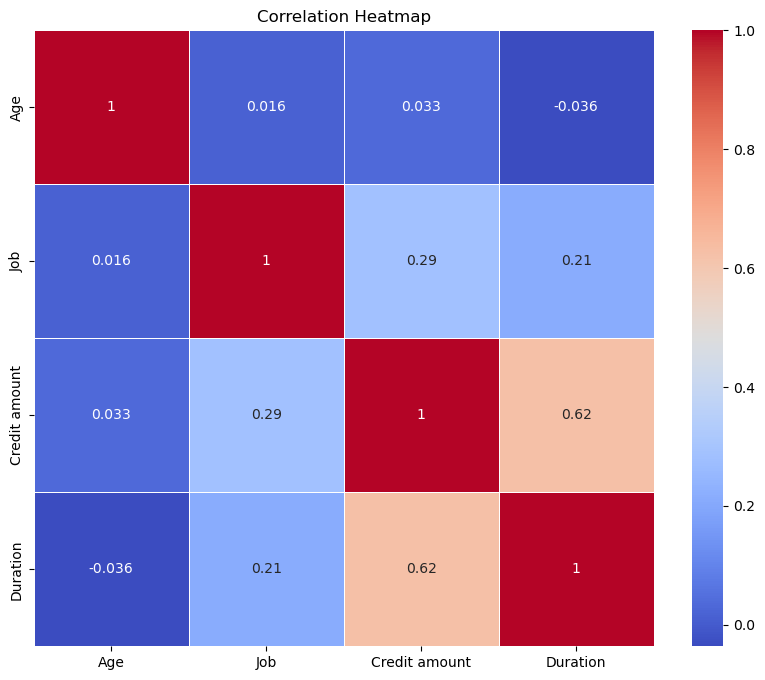

In [8]:

def create_heatmap(df):
    corr_matrix = df.corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
    plt.title('Correlation Heatmap')
    plt.show()


create_heatmap(df)

In [9]:
for column in df.columns:
    value_counts = df[column].value_counts().reset_index()
    exited_counts = df[df['Risk'] == 'bad'][column].value_counts()

    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=value_counts['index'],
        y=value_counts[column],
        name='Total'
    ))

    fig.add_trace(go.Bar(
        x=exited_counts.index,
        y=exited_counts,
        name='Risk'
    ))

    fig.update_layout(
        title=f"Value Counts: {column}",
        xaxis_title=column,
        yaxis_title="Count",
        barmode='stack'
    )

    fig.show()

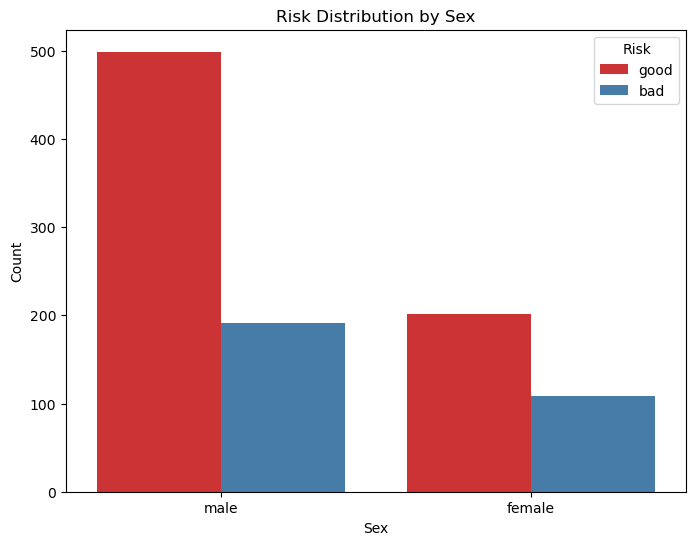

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='Risk', data=df, palette='Set1')
plt.title("Risk Distribution by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Risk")
plt.show()

In [11]:
age_labels = ['19-27', '27-33', '33-42', '42+']

# Define age group cutoff points based on percentiles
age_cutoffs = [0, 27, 33, 42, float('inf')]

# Create a new column 'AgeGroup' based on age cutoffs
df['AgeGroup'] = pd.cut(df['Age'], bins=age_cutoffs, labels=age_labels, right=False)

# Count the occurrences of each age group
age_group_counts = df['AgeGroup'].value_counts()

# Sort the age groups based on their labels
age_group_counts = age_group_counts.sort_index()

# Display the counts of each age group
print(age_group_counts)

19-27    240
27-33    243
33-42    260
42+      257
Name: AgeGroup, dtype: int64


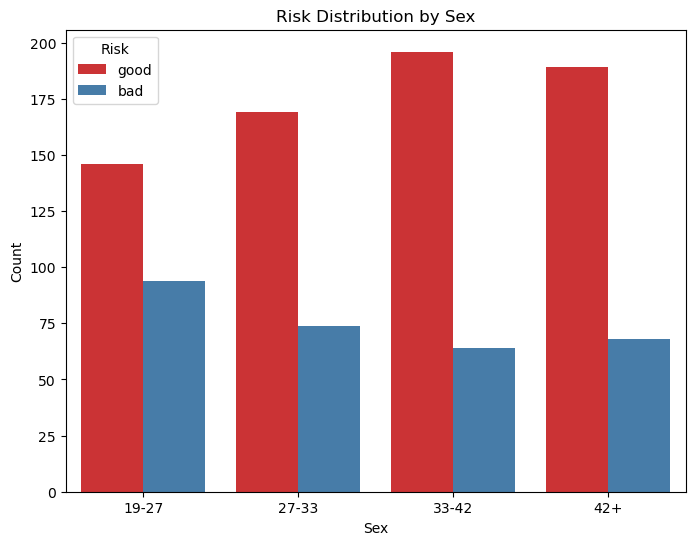

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='AgeGroup', hue='Risk', data=df, palette='Set1')
plt.title("Risk Distribution by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Risk")
plt.show()

In [13]:
fig = px.histogram(df, x='Housing', color='Risk', barmode='group')

# Customize the plot layout
fig.update_layout(title="Distribution of Housing with Risk",
                  xaxis_title="Housing",
                  yaxis_title="Count")

# Display the plot
fig.show()

In [14]:
table = pd.pivot_table(df, values='Risk', index=['Sex','AgeGroup'],
                       columns=['Purpose'], aggfunc='size')
table

Purpose          business  car  domestic appliances  education  \
Sex    AgeGroup                                                  
female 19-27            7   32                    4          7   
       27-33            6   22                    2          3   
       33-42            4   23                    0          8   
       42+              2   17                    0          6   
male   19-27           12   28                    1          2   
       27-33           22   58                    0         10   
       33-42           27   74                    2         11   
       42+             17   83                    3         12   

Purpose          furniture/equipment  radio/TV  repairs  vacation/others  
Sex    AgeGroup                                                           
female 19-27                      39        33        3                0  
       27-33                      16        20        0                1  
       33-42                      11         8        0                0  
       42+                         8        24        2                2  
male   19-27                      22        47        3                0  
       27-33                      31        45        3                4  
       33-42                      26        59        4                3  
       42+                        28        44        7                2

In [15]:
table = pd.pivot_table(df, values='Credit amount', index=['Sex','AgeGroup'],
                       columns=['Purpose'], aggfunc='sum')
table

Purpose          business     car  domestic appliances  education  \
Sex    AgeGroup                                                     
female 19-27        15176  114856                 4126      24752   
       27-33        14404   71418                 4333       4146   
       33-42        16399   63105                    0      12980   
       42+          14734   67375                    0       9339   
male   19-27        63577  106595                 1424       4316   
       27-33        97629  216633                    0      40923   
       33-42       101952  289206                 2487      28658   
       42+          79459  340693                 5606      44759   

Purpose          furniture/equipment  radio/TV  repairs  vacation/others  
Sex    AgeGroup                                                           
female 19-27                  115526     82444     5570                0  
       27-33                   39855     58318        0            18424  
       33-42                   30401     16078        0                0  
       42+                     19548     47204     5062            16537  
male   19-27                   55710    120335     2628                0  
       27-33                  115919    128764     4360            27853  
       33-42                   78178    154707    17748            18677  
       42+                     99988     88693    24650            17021

In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def fill_missing_values(df, target_column):
    tmpdf = df.copy()
    if target_column == 'Saving accounts':
        imputer = SimpleImputer(strategy='most_frequent')
        tmpdf['Checking account'] = imputer.fit_transform(tmpdf[['Checking account']])
    else:
        imputer = SimpleImputer(strategy='most_frequent')
        tmpdf['Saving accounts'] = imputer.fit_transform(tmpdf[['Saving accounts']])
    categorical_columns = tmpdf.select_dtypes(include='object').columns
    categorical_columns = categorical_columns.drop(target_column)
    le = LabelEncoder()
    tmpdf[categorical_columns] = tmpdf[categorical_columns].apply(lambda x: le.fit_transform(x.astype(str)))
    missing = tmpdf[tmpdf[target_column].isna()]
    not_missing = tmpdf[~tmpdf[target_column].isna()]

    le_target = LabelEncoder()
    target_encoded = le_target.fit_transform(not_missing[target_column].astype(str))
    X = not_missing.drop(target_column, axis=1)
    y = target_encoded
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    X_missing = missing.drop(target_column, axis=1)
    missing_pred = model.predict(X_missing)
    missing_pred_decoded = le_target.inverse_transform(missing_pred)

    df.loc[df[target_column].isna(), target_column] = missing_pred_decoded

    return df

df2 = df.copy()
df2 = df2.drop(columns=['AgeGroup'])
df2 = fill_missing_values(df2, 'Saving accounts')
df2 = fill_missing_values(df2, 'Checking account')
df2


Accuracy: 0.7134146341463414
Accuracy: 0.5983606557377049


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,little,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,moderate,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


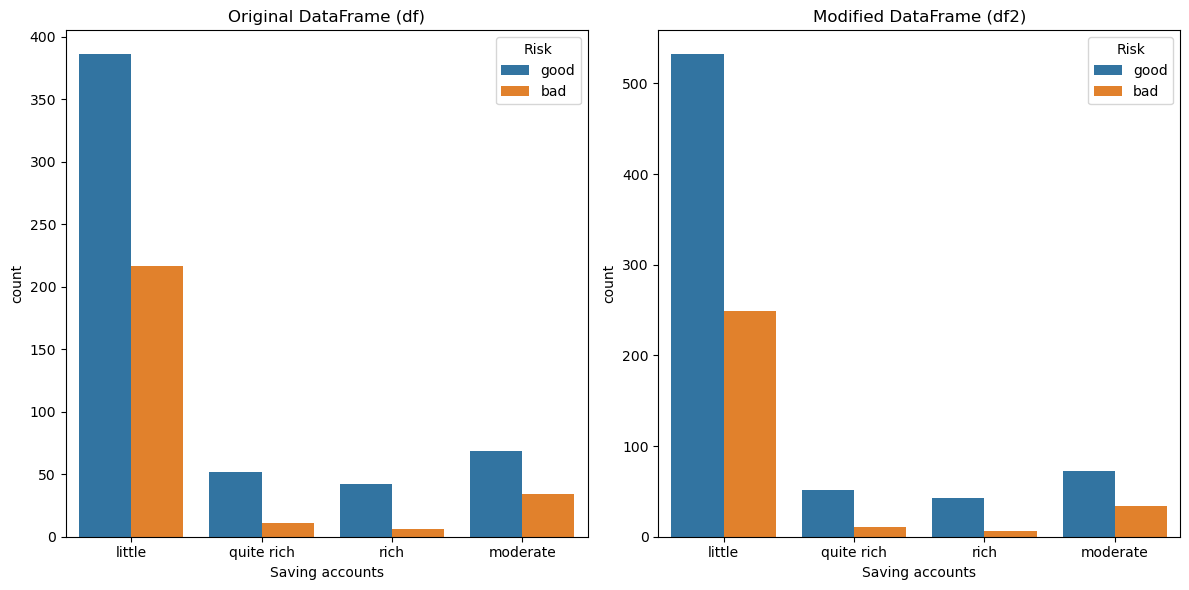

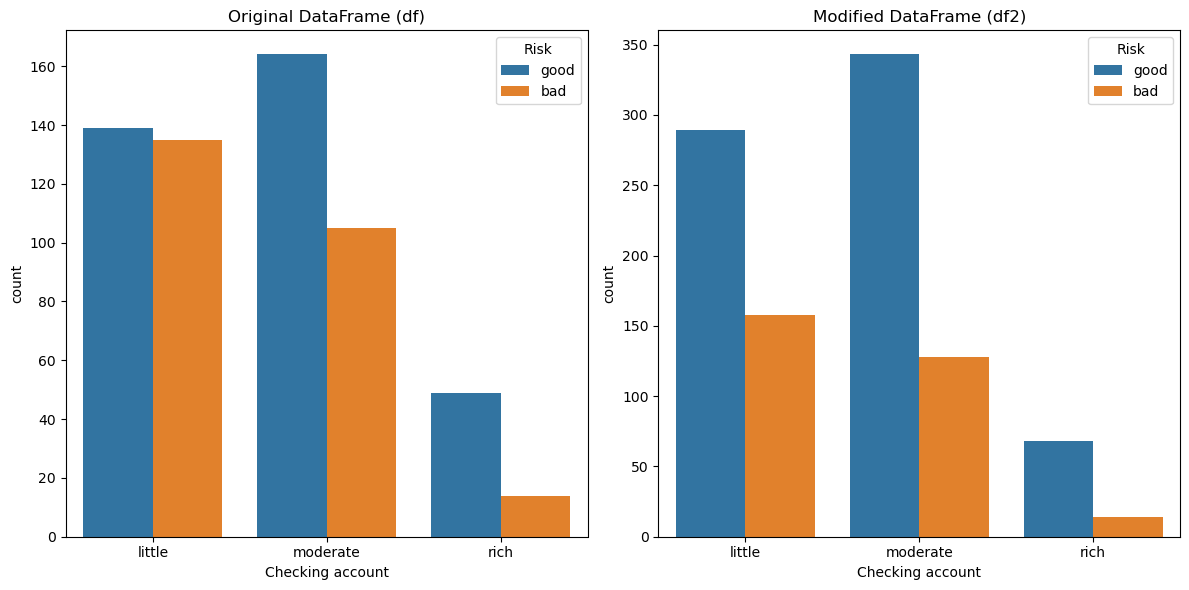

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Saving accounts', hue='Risk')
plt.title('Original DataFrame (df)')

plt.subplot(1, 2, 2)
sns.countplot(data=df2, x='Saving accounts', hue='Risk')
plt.title('Modified DataFrame (df2)')

plt.tight_layout()
plt.show()

# Compare 'Checking account' column
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Checking account', hue='Risk')
plt.title('Original DataFrame (df)')

plt.subplot(1, 2, 2)
sns.countplot(data=df2, x='Checking account', hue='Risk')
plt.title('Modified DataFrame (df2)')

plt.tight_layout()
plt.show()

In [31]:
age_labels = ['19-27', '27-33', '33-42', '42+']

# Define age group cutoff points based on percentiles
age_cutoffs = [0, 27, 33, 42, float('inf')]

# Create a new column 'AgeGroup' based on age cutoffs
df2['AgeGroup'] = pd.cut(df2['Age'], bins=age_cutoffs, labels=age_labels, right=False)

# Count the occurrences of each age group
age_group_counts = df2['AgeGroup'].value_counts()

# Sort the age groups based on their labels
age_group_counts = age_group_counts.sort_index()

# Display the counts of each age group
print(age_group_counts)

19-27    240
27-33    243
33-42    260
42+      257
Name: AgeGroup, dtype: int64


In [32]:
def one_hot_encoder(df, columns):
    encoder = OneHotEncoder()
    encoded_features = encoder.fit_transform(df[columns]).toarray()
    one_hot_encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(columns))
    df = pd.concat([df, one_hot_encoded_df], axis=1)
    df = df.drop(columns=columns)
    return df
one_hot_columns = ['Job','Housing','Saving accounts','Checking account','Purpose','AgeGroup','Sex']
df2 = one_hot_encoder(df2, one_hot_columns)
df2.head()

c:\Users\volka\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Age,Credit amount,Duration,Risk,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,...,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,AgeGroup_19-27,AgeGroup_27-33,AgeGroup_33-42,AgeGroup_42+,Sex_female,Sex_male
0,67,1169,6,good,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,22,5951,48,bad,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,49,2096,12,good,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,45,7882,42,good,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,53,4870,24,bad,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [33]:
df2

,Age,Credit amount,Duration,Risk,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,...,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,AgeGroup_19-27,AgeGroup_27-33,AgeGroup_33-42,AgeGroup_42+,Sex_female,Sex_male
0,67,1169,6,good,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,22,5951,48,bad,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,49,2096,12,good,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,45,7882,42,good,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,53,4870,24,bad,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1736,12,good,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
996,40,3857,30,good,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
997,38,804,12,good,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
998,23,1845,45,bad,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


XGBClassifier Accuracy: 0.735
XGBClassifier Training Time: 0.06101274490356445
XGBClassifier Prediction Speed: 0.002000093460083008
XGBClassifier R-squared: -0.2741916095684578
XGBClassifier MSE: 0.265

Logistic Regression Accuracy: 0.695
Logistic Regression Training Time: 0.019004344940185547
Logistic Regression Prediction Speed: 0.0010001659393310547
Logistic Regression R-squared: -0.46652241855992305
Logistic Regression MSE: 0.305

ANN Accuracy: 0.705
ANN Training Time: 0.08401989936828613
ANN Prediction Speed: 0.0010004043579101562
ANN R-squared: -0.4184397163120568
ANN MSE: 0.295


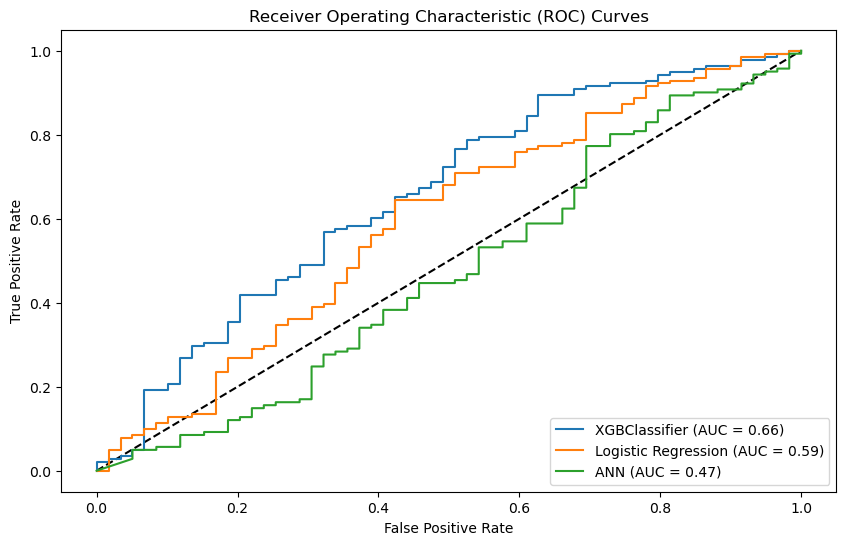

In [34]:
df2['Risk'] = df2['Risk'].map({'bad': 0, 'good': 1})
X = df2.drop('Risk', axis=1)
y = df2['Risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBClassifier
start_time = time.time()
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
end_time = time.time()
xgb_training_time = end_time - start_time

start_time = time.time()
xgb_y_pred = xgb_model.predict(X_test)
end_time = time.time()
xgb_prediction_speed = end_time - start_time

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_r2_score = r2_score(y_test, xgb_y_pred)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)

print("XGBClassifier Accuracy:", xgb_accuracy)
print("XGBClassifier Training Time:", xgb_training_time)
print("XGBClassifier Prediction Speed:", xgb_prediction_speed)
print("XGBClassifier R-squared:", xgb_r2_score)
print("XGBClassifier MSE:", xgb_mse)

# Logistic Regression
start_time = time.time()
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
end_time = time.time()
logreg_training_time = end_time - start_time

start_time = time.time()
logreg_y_pred = logreg_model.predict(X_test)
end_time = time.time()
logreg_prediction_speed = end_time - start_time

logreg_accuracy = accuracy_score(y_test, logreg_y_pred)
logreg_r2_score = r2_score(y_test, logreg_y_pred)
logreg_mse = mean_squared_error(y_test, logreg_y_pred)

print("\nLogistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Training Time:", logreg_training_time)
print("Logistic Regression Prediction Speed:", logreg_prediction_speed)
print("Logistic Regression R-squared:", logreg_r2_score)
print("Logistic Regression MSE:", logreg_mse)

# ANN (Multi-Layer Perceptron Classifier)
start_time = time.time()
ann_model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)
ann_model.fit(X_train, y_train)
end_time = time.time()
ann_training_time = end_time - start_time

start_time = time.time()
ann_y_pred = ann_model.predict(X_test)
end_time = time.time()
ann_prediction_speed = end_time - start_time

ann_accuracy = accuracy_score(y_test, ann_y_pred)
ann_r2_score = r2_score(y_test, ann_y_pred)
ann_mse = mean_squared_error(y_test, ann_y_pred)

print("\nANN Accuracy:", ann_accuracy)
print("ANN Training Time:", ann_training_time)
print("ANN Prediction Speed:", ann_prediction_speed)
print("ANN R-squared:", ann_r2_score)
print("ANN MSE:", ann_mse)

# ROC curves
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')

# XGBClassifier
xgb_y_prob = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_y_prob)
fpr, tpr, _ = roc_curve(y_test, xgb_y_prob)
plt.plot(fpr, tpr, label='XGBClassifier (AUC = {:.2f})'.format(xgb_auc))

# Logistic Regression
logreg_y_prob = logreg_model.predict_proba(X_test)[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_y_prob)
fpr, tpr, _ = roc_curve(y_test, logreg_y_prob)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(logreg_auc))

# ANN
ann_y_prob = ann_model.predict_proba(X_test)[:, 1]
ann_auc = roc_auc_score(y_test, ann_y_prob)
fpr, tpr, _ = roc_curve(y_test, ann_y_prob)
plt.plot(fpr, tpr, label='ANN (AUC = {:.2f})'.format(ann_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [37]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model = LogisticRegression(solver='liblinear')
import warnings
warnings.filterwarnings("ignore")


Best XGBClassifier Accuracy: 0.725
Best XGBClassifier AUC: 0.6962375285491044
Best XGBClassifier Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}

Best Logistic Regression Accuracy: 0.705
Best Logistic Regression AUC: 0.5893737228032216
Best Logistic Regression Parameters: {'C': 0.1, 'solver': 'lbfgs'}

Best ANN Accuracy: 0.705
Best ANN AUC: 0.4832311575910566
Best ANN Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (50,)}
ANN Training Time: 0.06701493263244629
ANN Prediction Speed: 0.0010004043579101562
ANN R-squared: -0.4184397163120568
ANN MSE: 0.295


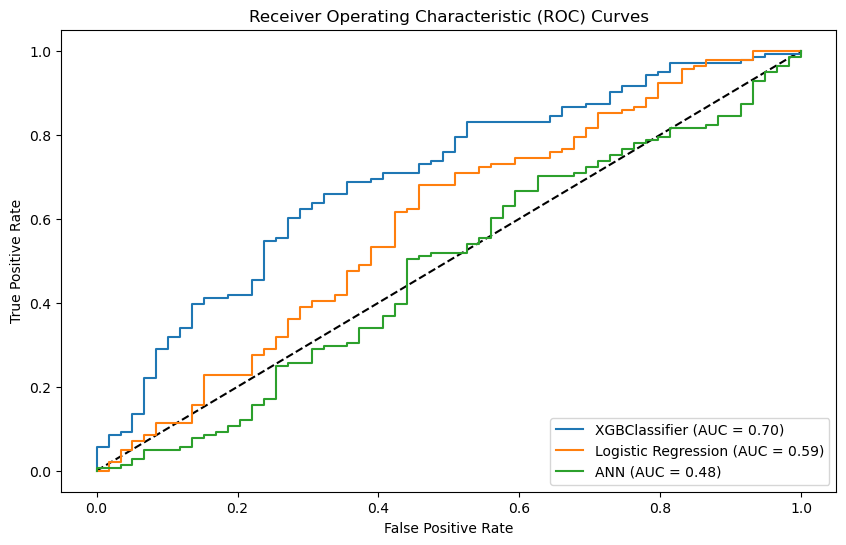

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, mean_squared_error
import time

# Hyperparameter tuning for XGBClassifier
xgb_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000]
}

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train, y_train)

best_xgb_model = xgb_grid_search.best_estimator_
best_xgb_y_pred = best_xgb_model.predict(X_test)
best_xgb_y_prob = best_xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, best_xgb_y_prob)

print("Best XGBClassifier Accuracy:", accuracy_score(y_test, best_xgb_y_pred))
print("Best XGBClassifier AUC:", xgb_auc)
print("Best XGBClassifier Parameters:", xgb_grid_search.best_params_)

# Hyperparameter tuning for Logistic Regression
logreg_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

logreg_grid_search = GridSearchCV(estimator=logreg_model, param_grid=logreg_param_grid, cv=5)
logreg_grid_search.fit(X_train, y_train)

best_logreg_model = logreg_grid_search.best_estimator_
best_logreg_y_pred = best_logreg_model.predict(X_test)
best_logreg_y_prob = best_logreg_model.predict_proba(X_test)[:, 1]
logreg_auc = roc_auc_score(y_test, best_logreg_y_prob)

print("\nBest Logistic Regression Accuracy:", accuracy_score(y_test, best_logreg_y_pred))
print("Best Logistic Regression AUC:", logreg_auc)
print("Best Logistic Regression Parameters:", logreg_grid_search.best_params_)

# Hyperparameter tuning for ANN
ann_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01]
}

ann_grid_search = GridSearchCV(estimator=ann_model, param_grid=ann_param_grid, cv=5)
ann_grid_search.fit(X_train, y_train)

best_ann_model = ann_grid_search.best_estimator_

start_time = time.time()
best_ann_model.fit(X_train, y_train)
ann_training_time = time.time() - start_time

start_time = time.time()
best_ann_y_pred = best_ann_model.predict(X_test)
ann_prediction_speed = time.time() - start_time

best_ann_y_prob = best_ann_model.predict_proba(X_test)[:, 1]
ann_auc = roc_auc_score(y_test, best_ann_y_prob)
ann_r2_score = r2_score(y_test, best_ann_y_pred)
ann_mse = mean_squared_error(y_test, best_ann_y_pred)

print("\nBest ANN Accuracy:", accuracy_score(y_test, best_ann_y_pred))
print("Best ANN AUC:", ann_auc)
print("Best ANN Parameters:", ann_grid_search.best_params_)
print("ANN Training Time:", ann_training_time)
print("ANN Prediction Speed:", ann_prediction_speed)
print("ANN R-squared:", ann_r2_score)
print("ANN MSE:", ann_mse)

# ROC curves
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')

# XGBClassifier ROC curve
fpr, tpr, _ = roc_curve(y_test, best_xgb_y_prob)
plt.plot(fpr, tpr, label='XGBClassifier (AUC = {:.2f})'.format(xgb_auc))

# Logistic Regression ROC curve
fpr, tpr, _ = roc_curve(y_test, best_logreg_y_prob)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(logreg_auc))

# ANN ROC curve
fpr, tpr, _ = roc_curve(y_test, best_ann_y_prob)
plt.plot(fpr, tpr, label='ANN (AUC = {:.2f})'.format(ann_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [42]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,AgeGroup
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,42+
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,19-27
2,49,male,1,own,little,NaN,2096,12,education,good,42+
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,42+
4,53,male,2,free,little,little,4870,24,car,bad,42+
...,...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good,27-33
996,40,male,3,own,little,little,3857,30,car,good,33-42
997,38,male,2,own,little,NaN,804,12,radio/TV,good,33-42
998,23,male,2,free,little,little,1845,45,radio/TV,bad,19-27
